In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.datasets.factory  import FactoryDataset 
from pytvision.datasets.datasets import Dataset 
from pytvision.datasets.fersynthetic  import SyntheticFaceDataset
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
# from torchlib.datasets.factory  import FactoryDataset 
# from torchlib.datasets.datasets import Dataset 
# from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
no_cuda=False
seed=1
gpu=1
batch_size=60
workers=10
num_input_channels=3

print(pathname)
print(projectnet)


/home/fernandez/.datasets
../out/netruns


In [3]:
!ls ../out/netruns/

baseline_preactresnet18_cross_adam_affectnetdark_fold0_weights_000
baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000
baseline_preactresnet18_cross_adam_ferp_000
baseline_preactresnet18_cross_sgd_affect_000
baseline_preactresnet18_cross_sgd_affectnet_000
baseline_preactresnet18_cross_sgd_affectnet_weights_000
ferbase_preactresnet18_cross_adam_bu3dfe_fold0_000
ferbase_preactresnet18_cross_adam_real_bu3dfe_fold0_000
ferbase_preactresnet18_cross_sgd_real_bu3dfe_fold0_000


In [4]:
name = 'baseline_preactresnet18_cross_adam_ferp_000'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/netruns/baseline_preactresnet18_cross_adam_ferp_000
../out/netruns/baseline_preactresnet18_cross_adam_ferp_000/models/model_best.pth.tar


## Load model

In [5]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

=> loading checkpoint '../out/netruns/baseline_preactresnet18_cross_adam_ferp_000/models/model_best.pth.tar'
=> loaded checkpoint for preactresnet18 arch!


In [6]:
name_dataset=FactoryDataset.affect
subset=FactoryDataset.validation

nactores=10
kfold=0
idenselect = [] #np.arange(nactores) + kfold*nactores
breal=True


data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=subset, 
        #idenselect=idenselect,
        download=True ),
    num_channels=num_input_channels,
    transform=get_transforms_det(network.size_input)
    )

# data = SyntheticFaceDataset(
#     data=FactoryDataset.factory(
#         pathname=pathname, 
#         name=name_dataset, 
#         subset=subset, 
#         #idenselect=idenselect,
#         download=True 
#         ),
#     pathnameback='~/.datasets/coco', 
#     generate='image_and_label',
#     ext='jpg',
#     count=2000,
#     num_channels=network.num_input_channels,
#     iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
#     #iluminate=True, angle=45, translation=0.1, warp=0.0, factor=0.0,
#     transform_image=get_transforms_det( network.size_input )
#     )


dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
67
4000


In [7]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame( np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')       

print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 67/67 [00:10<00:00,  6.41it/s]


dir: ../out/netruns/baseline_preactresnet18_cross_adam_ferp_000
DONE!!!


In [8]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8
0,0.999861,6.206946e-07,2.588902e-05,0.000112,3.737705e-07,1.480863e-14,6.261883e-11,2.000840e-09,7.0
1,0.770028,1.003492e-06,1.557262e-04,0.229369,4.325655e-04,7.872593e-08,1.876710e-06,1.228591e-05,0.0
2,0.995836,3.634784e-03,6.531939e-05,0.000364,1.004492e-04,3.076871e-11,3.073085e-09,3.077699e-07,0.0
3,0.999906,3.679702e-05,1.131254e-06,0.000055,1.149523e-06,3.491662e-09,1.485161e-09,8.559946e-11,6.0
4,0.999985,1.544833e-08,3.703779e-07,0.000014,4.020848e-07,3.571206e-16,1.684685e-11,9.224966e-10,0.0


In [9]:
result = df.as_matrix()
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

# print('Accuracy : %f' % acc)
# print('Precision : %f' % precision)
# print('Recall : %f' % recall)
# print('F1 score : %f' % f1_score)
# print("")
print('|Acc\t|Prec\t|Rec\t|F1\t|')
print( '|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|{:0.3f}\t|'.format(acc,precision,recall,f1_score).replace('.',',')  )

print()
print( '{:0.3f}\n{:0.3f}\n{:0.3f}\n{:0.3f}'.format(acc*100,precision*100,recall*100,f1_score*100).replace('.',',')  )

|Acc	|Prec	|Rec	|F1	|
|0,279	|0,447	|0,279	|0,343	|

27,850
44,749
27,850
34,333


In [34]:
metric = metrics.classification_report(y, yhat)
print(metric)

              precision    recall  f1-score   support

         0.0       0.17      0.94      0.28       500
         1.0       0.49      0.62      0.55       500
         2.0       0.42      0.16      0.24       500
         3.0       0.41      0.13      0.20       500
         4.0       0.38      0.09      0.15       500
         5.0       0.75      0.01      0.01       500
         6.0       0.62      0.05      0.09       500
         7.0       0.00      0.00      0.00       500

   micro avg       0.25      0.25      0.25      4000
   macro avg       0.41      0.25      0.19      4000
weighted avg       0.41      0.25      0.19      4000



In [35]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[471  19   5   3   1   0   1   0]
 [173 311   6   4   5   0   1   0]
 [333  57  82  16   4   0   8   0]
 [393  30   6  65   4   0   2   0]
 [408  23   9  12  46   0   1   1]
 [369  49  14  24  39   3   2   0]
 [321  44  67  23  19   1  25   0]
 [379 102   6  10   3   0   0   0]]


Normalized confusion matrix


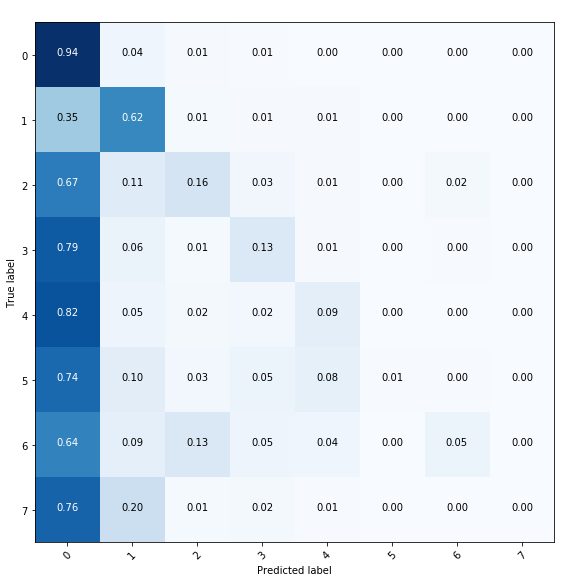

In [36]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.show()